<a href="https://colab.research.google.com/github/vadim-privalov/sberbank_data_analysis/blob/master/%D1%84%D0%B8%D0%BD%D0%B0%D0%BB_%D0%BC%D0%B0%D0%B92021_%D0%B8%D1%81%D0%BF%D1%80%D0%B0%D0%B2%D0%BB%D0%B5%D0%BD%D0%BD%D1%8B%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В финальном проекты мы произведем обработку новостной ленты СМИ "Лента.ру", произведем обработку полученного текста с помощью библиотеки NLTK, выделим наиболее часто встречающиеся слова и построим визуализацию нашей выборки. Затем с помощью библиотеки Natasha отберем именнованные сущьности (названия организаций, людей и локаций) из нашей новостной выборки и построим связь между ними (сущьностями) при помощи Графа


Т.к. я предварительно скачал с интернет ресурса Каглл выборку новостей "Лента.ру" в виде файла с расширением csv на Гугл диск, то подключаем его для загрузки датафрейма 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загружаем и устанавливаем необходимые библиотеки для обработки датафрейма, визуализации и обработки текста

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
pd.options.display.max_rows = 10

In [ ]:
pip install -U nltk

Requirement already up-to-date: nltk in /usr/local/lib/python3.7/dist-packages (3.6.2)


In [ ]:
import nltk 
nltk.download("stopwords")
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Загружаем и возвращаем наш датафрейм новостной ленты

In [ ]:
df = pd.read_csv(filepath_or_buffer = "/content/drive/MyDrive/lenta-ru-news.csv",
                 sep = ',')  

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18
...,...,...,...,...,...,...
800970,https://lenta.ru/news/2019/12/14/shnur/,Шнуров раскритиковал Гагарину на «Голосе»,Певец Сергей Шнуров раскритиковал свою коллегу...,NaN,ТВ и радио,2019/12/14
800971,https://lenta.ru/news/2019/12/14/dolg/,В России предложили изменить правила взыскания...,Министерство юстиции России предложило изменит...,NaN,Все,2019/12/14
800972,https://lenta.ru/news/2019/12/14/dark_euro/,В России назвали «черную дату» для Европы,Испытание США ранее запрещенной Договором о ли...,NaN,Политика,2019/12/14
800973,https://lenta.ru/news/2019/12/14/meteo/,Россиянам пообещали аномально теплую погоду,В ближайшие дни в европейской части России пог...,NaN,Общество,2019/12/14


Нас интересует текст в столбце 'text', но т.к. нам нужны только новости связанные с экономикой, то выбираем уникальные значения из столбца 'tags', в   котором кратко описывается принадлежность текста к той или иной сфере деятельности 

In [ ]:
df.tags.unique() # уникальные значения в столбце tags, что бы выбрать новости про экономику

array(['Первая мировая', 'Все', nan, 'Прибалтика', 'Кино', 'Преступность',
       'Общество', 'Происшествия', 'Искусство', 'Бизнес', 'Техника',
       'ТВ и радио', 'Политика', 'Пресса', 'Музыка', 'Люди', 'Звери',
       'Игры', 'Госэкономика', 'Гаджеты', 'Наука', 'Еда', 'Рынки',
       'Деньги', 'Летние виды', 'Интернет', 'Театр', 'Конфликты',
       'Реклама', 'Космос', 'Бокс и ММА', 'Футбол', 'Книги',
       'Зимние виды', 'Достижения', 'Coцсети', 'Вещи', 'События',
       'Средняя Азия', 'Украина', 'Закавказье', 'Белоруссия', 'Молдавия',
       'Софт', 'Квартира', 'Город', 'Дача', 'Офис', 'Оружие', 'Мнения',
       'Москва', 'Регионы', 'Полиция и спецслужбы', 'Криминал',
       'Следствие и суд', 'Движение', 'Производители', 'Мировой бизнес',
       'Финансы компаний', 'Деловой климат', 'Мир', 'Россия', 'Часы',
       'Явления', 'Стиль', 'Инструменты', 'Вооружение', 'Вкусы',
       'Страноведение', 'Госрегулирование', 'История', 'Внешний вид',
       'Автобизнес', 'Аналитика рынка'

Получив уникальные значения заголовков, нам необходимо произвести выборку экономических новостей, для чего передаем наш столбец 'tags' в индекс.

In [ ]:
df1 = df.set_index('tags') # индексируем tags

Из существующего датафрейма выбираем только те строки, где говорится про экономику, названия строк выбираем из списка уникальных значений, полученных выше. И возвращаем новый датафрейм df2

In [ ]:
df2 = df1.loc[['Рынки', 'Деньги', 'Мировой бизнес', 'Финансы компаний', 
               'Деловой климат', 'Аналитика рынка', 'Экономика']] # выборка экономических новостей

Извлекаем весь текст из стобца text

In [ ]:
ved = df2['text'].tolist() # извлекаем тест из столбца text

In [ ]:
ved

['Акции Сбербанка утром 14 января подорожали на полпроцента и впервые с марта 2011 года стали стоить больше ста рублей. Правда, уже к 12:00 по московскому времени ажиотаж инвесторов спал, и акции опустились до 99,97 рубля. Инвесторы активно скупают акции крупнейших российских госбанков уже несколько торговых сессий подряд. В минувшую пятницу, 11 января, лидерами торгов на Московской бирже стали акции ВТБ, которые поднялись в цене на 4,2 процента. При этом по объемам торгов ценные бумаги ВТБ обогнали обычных лидеров рынка - "Роснефть" и "Газпром" - и уступили лишь Сбербанку. 14 января по акциям ВТБ также зафиксированы повышенные объемы торгов. Акции подорожали на 0,63 процента до 5,79 копейки при росте индекса ММВБ на 0,86 процента. Почему инвесторы скупают именно акции российских госбанков, неизвестно - никаких новостей от госбанков, которые бы могли привести к значительному увеличению стоимости их акций, с начала 2013 года не было. Акции Сбербанка в ходе последней торговой сессии 2012

Что производить необходимые манипуляции с полученным текстом надо узнать тип полученного файла

In [ ]:
type(ved)

list

у нас получился Лист (list), а для дальнейшей работы надо лист преобразовать в строку (str). Производим преобразование.

In [ ]:
ved = [str(i) for i in ved]
ved = ",".join(ved)

In [ ]:
type(ved) # получилась Строка

str

Начинаем обработку текста с помощью библиотеки NLTK и для начала разбиваем наш текст на параграфы

In [ ]:
paragraphs = [sen for sen in ved.split('\n') if sen]  # разбиваем на параграфы
paragraphs[:5]

In [ ]:
len(paragraphs) # количество параграфов

3

Наш текст уже разбит на предложения, поэтому сразу проводим его разбивку на составляющие (токены)

In [ ]:
sentences = [nltk.sent_tokenize(paragraph) for paragraph in paragraphs] 
sentences = [sen for sublist in sentences for sen in sublist]
sentences[:10]

['Акции Сбербанка утром 14 января подорожали на полпроцента и впервые с марта 2011 года стали стоить больше ста рублей.',
 'Правда, уже к 12:00 по московскому времени ажиотаж инвесторов спал, и акции опустились до 99,97 рубля.',
 'Инвесторы активно скупают акции крупнейших российских госбанков уже несколько торговых сессий подряд.',
 'В минувшую пятницу, 11 января, лидерами торгов на Московской бирже стали акции ВТБ, которые поднялись в цене на 4,2 процента.',
 'При этом по объемам торгов ценные бумаги ВТБ обогнали обычных лидеров рынка - "Роснефть" и "Газпром" - и уступили лишь Сбербанку.',
 '14 января по акциям ВТБ также зафиксированы повышенные объемы торгов.',
 'Акции подорожали на 0,63 процента до 5,79 копейки при росте индекса ММВБ на 0,86 процента.',
 'Почему инвесторы скупают именно акции российских госбанков, неизвестно - никаких новостей от госбанков, которые бы могли привести к значительному увеличению стоимости их акций, с начала 2013 года не было.',
 'Акции Сбербанка в ход

In [ ]:
len(sentences) # всего предложений

110087

Проводим дальнейшую разбивку текста на более мелкие составляющие токены (слова)

In [ ]:
tokens_sentences = [nltk.word_tokenize(sentence) for sentence in sentences] # токенизация по словам

print(tokens_sentences[:10])

[['Акции', 'Сбербанка', 'утром', '14', 'января', 'подорожали', 'на', 'полпроцента', 'и', 'впервые', 'с', 'марта', '2011', 'года', 'стали', 'стоить', 'больше', 'ста', 'рублей', '.'], ['Правда', ',', 'уже', 'к', '12:00', 'по', 'московскому', 'времени', 'ажиотаж', 'инвесторов', 'спал', ',', 'и', 'акции', 'опустились', 'до', '99,97', 'рубля', '.'], ['Инвесторы', 'активно', 'скупают', 'акции', 'крупнейших', 'российских', 'госбанков', 'уже', 'несколько', 'торговых', 'сессий', 'подряд', '.'], ['В', 'минувшую', 'пятницу', ',', '11', 'января', ',', 'лидерами', 'торгов', 'на', 'Московской', 'бирже', 'стали', 'акции', 'ВТБ', ',', 'которые', 'поднялись', 'в', 'цене', 'на', '4,2', 'процента', '.'], ['При', 'этом', 'по', 'объемам', 'торгов', 'ценные', 'бумаги', 'ВТБ', 'обогнали', 'обычных', 'лидеров', 'рынка', '-', '``', 'Роснефть', "''", 'и', '``', 'Газпром', "''", '-', 'и', 'уступили', 'лишь', 'Сбербанку', '.'], ['14', 'января', 'по', 'акциям', 'ВТБ', 'также', 'зафиксированы', 'повышенные', 'объем

Наши слова написаны как в верхнем, так и в нижнем регистре, что может привести к тому, что одно и то же слово будет восприниматься как два разных, поэтому все приводим к нижнему регистру

In [ ]:
# приведение к нижнему регистру

tokens_sentences = [[token.lower() for token in token_sentence] for token_sentence in tokens_sentences]

print(tokens_sentences[:10])

[['акции', 'сбербанка', 'утром', '14', 'января', 'подорожали', 'на', 'полпроцента', 'и', 'впервые', 'с', 'марта', '2011', 'года', 'стали', 'стоить', 'больше', 'ста', 'рублей', '.'], ['правда', ',', 'уже', 'к', '12:00', 'по', 'московскому', 'времени', 'ажиотаж', 'инвесторов', 'спал', ',', 'и', 'акции', 'опустились', 'до', '99,97', 'рубля', '.'], ['инвесторы', 'активно', 'скупают', 'акции', 'крупнейших', 'российских', 'госбанков', 'уже', 'несколько', 'торговых', 'сессий', 'подряд', '.'], ['в', 'минувшую', 'пятницу', ',', '11', 'января', ',', 'лидерами', 'торгов', 'на', 'московской', 'бирже', 'стали', 'акции', 'втб', ',', 'которые', 'поднялись', 'в', 'цене', 'на', '4,2', 'процента', '.'], ['при', 'этом', 'по', 'объемам', 'торгов', 'ценные', 'бумаги', 'втб', 'обогнали', 'обычных', 'лидеров', 'рынка', '-', '``', 'роснефть', "''", 'и', '``', 'газпром', "''", '-', 'и', 'уступили', 'лишь', 'сбербанку', '.'], ['14', 'января', 'по', 'акциям', 'втб', 'также', 'зафиксированы', 'повышенные', 'объем

Наш новостной текст "замусорен" знаками препинания и цифрами, которые в нашей задаче не нужны, поэтому избавляемся от них

In [ ]:
from string import punctuation

punctuation = punctuation + '»' + '«'
punctuation # стандартные пунктуационные символы

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~»«'

In [ ]:
tokens_sentences = [[token for token in token_sentence if token not in punctuation] 
                    for token_sentence in tokens_sentences] # удаление знаков пунктуации
print(tokens_sentences[:10])

[['акции', 'сбербанка', 'утром', '14', 'января', 'подорожали', 'на', 'полпроцента', 'и', 'впервые', 'с', 'марта', '2011', 'года', 'стали', 'стоить', 'больше', 'ста', 'рублей'], ['правда', 'уже', 'к', '12:00', 'по', 'московскому', 'времени', 'ажиотаж', 'инвесторов', 'спал', 'и', 'акции', 'опустились', 'до', '99,97', 'рубля'], ['инвесторы', 'активно', 'скупают', 'акции', 'крупнейших', 'российских', 'госбанков', 'уже', 'несколько', 'торговых', 'сессий', 'подряд'], ['в', 'минувшую', 'пятницу', '11', 'января', 'лидерами', 'торгов', 'на', 'московской', 'бирже', 'стали', 'акции', 'втб', 'которые', 'поднялись', 'в', 'цене', 'на', '4,2', 'процента'], ['при', 'этом', 'по', 'объемам', 'торгов', 'ценные', 'бумаги', 'втб', 'обогнали', 'обычных', 'лидеров', 'рынка', '``', 'роснефть', "''", 'и', '``', 'газпром', "''", 'и', 'уступили', 'лишь', 'сбербанку'], ['14', 'января', 'по', 'акциям', 'втб', 'также', 'зафиксированы', 'повышенные', 'объемы', 'торгов'], ['акции', 'подорожали', 'на', '0,63', 'процен

In [ ]:
# удаление оставшихся токенов, которые не являются буквенными

tokens_sentences = [[token for token in token_sentence if token.isalpha()] 
                    for token_sentence in tokens_sentences]
print(tokens_sentences[:10])

[['акции', 'сбербанка', 'утром', 'января', 'подорожали', 'на', 'полпроцента', 'и', 'впервые', 'с', 'марта', 'года', 'стали', 'стоить', 'больше', 'ста', 'рублей'], ['правда', 'уже', 'к', 'по', 'московскому', 'времени', 'ажиотаж', 'инвесторов', 'спал', 'и', 'акции', 'опустились', 'до', 'рубля'], ['инвесторы', 'активно', 'скупают', 'акции', 'крупнейших', 'российских', 'госбанков', 'уже', 'несколько', 'торговых', 'сессий', 'подряд'], ['в', 'минувшую', 'пятницу', 'января', 'лидерами', 'торгов', 'на', 'московской', 'бирже', 'стали', 'акции', 'втб', 'которые', 'поднялись', 'в', 'цене', 'на', 'процента'], ['при', 'этом', 'по', 'объемам', 'торгов', 'ценные', 'бумаги', 'втб', 'обогнали', 'обычных', 'лидеров', 'рынка', 'роснефть', 'и', 'газпром', 'и', 'уступили', 'лишь', 'сбербанку'], ['января', 'по', 'акциям', 'втб', 'также', 'зафиксированы', 'повышенные', 'объемы', 'торгов'], ['акции', 'подорожали', 'на', 'процента', 'до', 'копейки', 'при', 'росте', 'индекса', 'ммвб', 'на', 'процента'], ['почем

Очищаем текст от "стоп-слов" в русском языке, которые не несут смысловой нагрузки, но значительно увеличивая обьем обрабатываемого текста

In [ ]:
from nltk.corpus import stopwords # русские стоп-слова

stop_words = stopwords.words('russian')
print(stop_words)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [ ]:
stop_words += ['который', 'это', 'лента'] # дополнительно вводим два стоп-слова, слово - лента ввводим, что бы исключить ссылки на новостную ленту

In [ ]:
# удаление стоп слов русского языка
tokens_sentences = [[token for token in token_sentence if token not in stop_words] 
                    for token_sentence in tokens_sentences]
print(tokens_sentences[:10])

[['акции', 'сбербанка', 'утром', 'января', 'подорожали', 'полпроцента', 'впервые', 'марта', 'года', 'стали', 'стоить', 'ста', 'рублей'], ['правда', 'московскому', 'времени', 'ажиотаж', 'инвесторов', 'спал', 'акции', 'опустились', 'рубля'], ['инвесторы', 'активно', 'скупают', 'акции', 'крупнейших', 'российских', 'госбанков', 'несколько', 'торговых', 'сессий', 'подряд'], ['минувшую', 'пятницу', 'января', 'лидерами', 'торгов', 'московской', 'бирже', 'стали', 'акции', 'втб', 'которые', 'поднялись', 'цене', 'процента'], ['объемам', 'торгов', 'ценные', 'бумаги', 'втб', 'обогнали', 'обычных', 'лидеров', 'рынка', 'роснефть', 'газпром', 'уступили', 'лишь', 'сбербанку'], ['января', 'акциям', 'втб', 'также', 'зафиксированы', 'повышенные', 'объемы', 'торгов'], ['акции', 'подорожали', 'процента', 'копейки', 'росте', 'индекса', 'ммвб', 'процента'], ['почему', 'инвесторы', 'скупают', 'именно', 'акции', 'российских', 'госбанков', 'неизвестно', 'никаких', 'новостей', 'госбанков', 'которые', 'могли', 'п

Производим стэмминг нашего текста, т.е. одинаковые слова в различных падежах, склонениях приводим к одному виду

In [ ]:
from nltk.stem.snowball import SnowballStemmer 

porter = SnowballStemmer(language='russian') # стэммер
tokens_sentences = [[porter.stem(token) for token in token_sentence] for token_sentence in tokens_sentences]

# стэмминг нашего словаря
print(tokens_sentences[:10])

[['акц', 'сбербанк', 'утр', 'январ', 'подорожа', 'полпроцент', 'вперв', 'март', 'год', 'стал', 'сто', 'ста', 'рубл'], ['правд', 'московск', 'времен', 'ажиотаж', 'инвестор', 'спал', 'акц', 'опуст', 'рубл'], ['инвестор', 'активн', 'скупа', 'акц', 'крупн', 'российск', 'госбанк', 'нескольк', 'торгов', 'сесс', 'подряд'], ['минувш', 'пятниц', 'январ', 'лидер', 'торг', 'московск', 'бирж', 'стал', 'акц', 'втб', 'котор', 'подня', 'цен', 'процент'], ['объем', 'торг', 'цен', 'бумаг', 'втб', 'обогна', 'обычн', 'лидер', 'рынк', 'роснефт', 'газпр', 'уступ', 'лиш', 'сбербанк'], ['январ', 'акц', 'втб', 'такж', 'зафиксирова', 'повышен', 'объем', 'торг'], ['акц', 'подорожа', 'процент', 'копейк', 'рост', 'индекс', 'ммвб', 'процент'], ['поч', 'инвестор', 'скупа', 'имен', 'акц', 'российск', 'госбанк', 'неизвестн', 'никак', 'новост', 'госбанк', 'котор', 'могл', 'привест', 'значительн', 'увеличен', 'стоимост', 'акц', 'нача', 'год'], ['акц', 'сбербанк', 'ход', 'последн', 'торгов', 'сесс', 'год', 'закр', 'отме

In [ ]:
# повторное удаление стоп слов русского языка
tokens_sentences = [[token for token in token_sentence if token not in stop_words] 
                    for token_sentence in tokens_sentences]

print(tokens_sentences[:5])

[['акц', 'сбербанк', 'утр', 'январ', 'подорожа', 'полпроцент', 'вперв', 'март', 'год', 'стал', 'сто', 'ста', 'рубл'], ['правд', 'московск', 'времен', 'ажиотаж', 'инвестор', 'спал', 'акц', 'опуст', 'рубл'], ['инвестор', 'активн', 'скупа', 'акц', 'крупн', 'российск', 'госбанк', 'нескольк', 'торгов', 'сесс', 'подряд'], ['минувш', 'пятниц', 'январ', 'лидер', 'торг', 'московск', 'бирж', 'стал', 'акц', 'втб', 'котор', 'подня', 'цен', 'процент'], ['объем', 'торг', 'цен', 'бумаг', 'втб', 'обогна', 'обычн', 'лидер', 'рынк', 'роснефт', 'газпр', 'уступ', 'лиш', 'сбербанк']]


После обработки текста новостей про экономику, оцениваем размер нашего словаря по количеству отобранных слов. У нас получилось 1 410 107 слов

In [ ]:
tokens = [token for sublist in tokens_sentences for token in sublist]

len(tokens) # итоговое количество токенов, размер нашего словаря 

1410107

Выводим 10 наиболее часто встечающихся слов в нашем словаре

In [ ]:
from collections import Counter

tokens = [token for sublist in tokens_sentences for token in sublist]
freq_tokens = Counter(tokens)

freq_tokens.most_common(10) # наиболее часто встречающиеся токены

[('год', 21702),
 ('процент', 14369),
 ('рубл', 13157),
 ('росс', 12048),
 ('компан', 11527),
 ('доллар', 10179),
 ('котор', 8513),
 ('российск', 7925),
 ('такж', 6831),
 ('миллиард', 6560)]

Устанвливаем библиотеку WordCloud для отбора наиболее "важных" слов характерезующих наши новости

In [ ]:
pip install wordcloud

Визуализируем наиболее часто встечающиеся слова в наших новостях

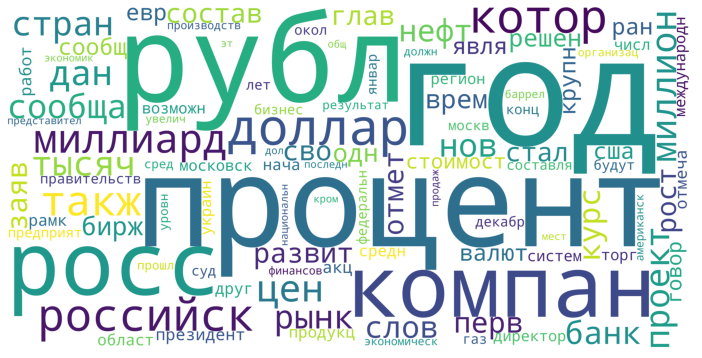

In [ ]:
# визуализация 100 наиболее частых токенов (базовое)
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
%matplotlib inline

wc = WordCloud(width=4000, height=2000, max_words=100, 
               background_color='white', mask=None).generate_from_frequencies(freq_tokens)

plt.figure(figsize=(10, 8))
plt.imshow(wc)
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

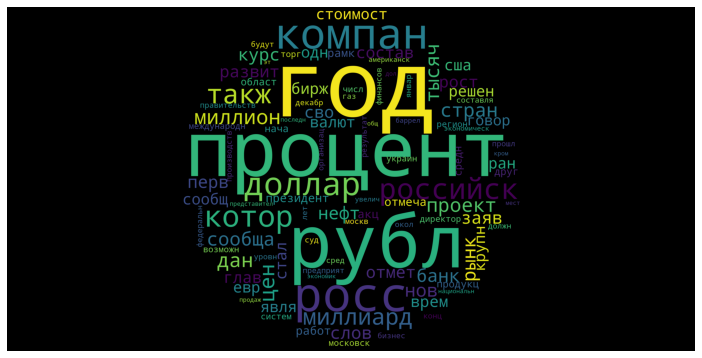

In [ ]:
# можем использовать и (или создавать) различные маски (круг)

import numpy as np

def create_circular_mask(h, w, center=None, radius=None):

    if center is None: 
        center = (int(w/2), int(h/2))
    if radius is None: 
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y-center[1]) **2)

    mask = dist_from_center <= radius
    mask = ~mask
    
    return mask

mask = create_circular_mask(2000, 4000)
mask = 255 * mask.astype(int)

wc = WordCloud(width=4000, height=2000, max_words=100, 
               background_color='black', mask=mask).generate_from_frequencies(freq_tokens)

plt.figure(figsize=(10, 8))
plt.imshow(wc)
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

Для оценки важности слов в нашем тексте создаем "мешок слов" и производим tf-idf преобразование, что бы отобрать, а затем отсеять наиболее/наименее часто встречающиеся слова нашего словаря

In [ ]:
# получаем мешок слов для нашего текста
from sklearn.feature_extraction.text import CountVectorizer

sk_corpus = [' '.join(token for token in sentence) for sentence in tokens_sentences]

vectorizer = CountVectorizer(vocabulary=list(freq_tokens.keys()))
X_bow = vectorizer.fit_transform(sk_corpus)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(vocabulary=list(freq_tokens.keys())) # tf-idf преобразование
X_tfidf = vectorizer.fit_transform(sk_corpus)

In [ ]:
# визуализируем наиболее/наименее часто встречающиеся токены
import pandas as pd

idf = pd.DataFrame(vectorizer.get_feature_names(), columns=['token'])
idf['idf'] = vectorizer.idf_

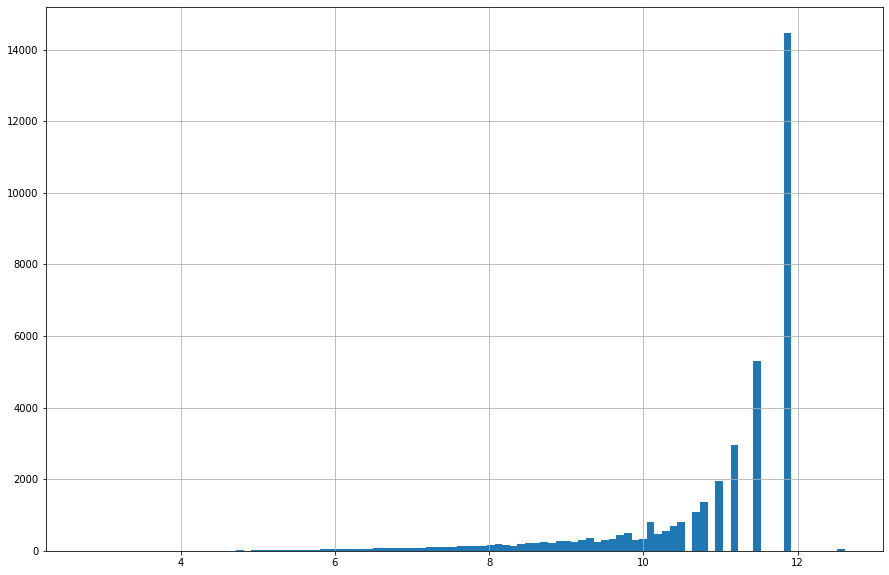

In [ ]:
idf.idf.hist(figsize=(15, 10), bins=100)

Смотрим на нашу гистограмму и видим, что наибольший вес имеют слова попавшие в промежуток от 7 до 9,5

In [ ]:
idf_tokens = idf[(idf.idf > 7) & (idf.idf < 9.5)].token.tolist() # фильтруем и выбираем наши токены в промежутке от 7 до 9,5
freq_tokens_idf = {key: freq_tokens[key] for key in idf_tokens}

Создадим маску для визуализации нашего отобранного "мешка слов" из заранее отбранной и загруженной на Гугл диск фигурки человека

In [ ]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline

Загружаем картинку человека и выводим числовой массив, описывающий фигуру. В нашем случае все числа 255, т.е. фигура выполнена в белом цвете и ее можно заполнять словами без предварительной обработки.

In [ ]:
wine_mask = np.array(Image.open("/content/drive/MyDrive/foto.png")) # загружаем нашу картинку человечка для маски
wine_mask 

array([[[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       ...,

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255

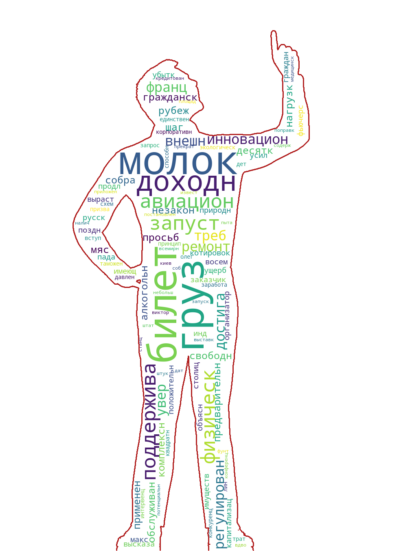

In [ ]:
# заполняем нашу маску токенами (100 слов из мешка слов)
wc = WordCloud(background_color="white", max_words=100, mask=wine_mask,
               stopwords=stopwords, contour_width=3, contour_color='firebrick').generate_from_frequencies(freq_tokens_idf)


# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

сохраняем полученную картинку на Гугл диск, для использования в презентациях, демонстрациях и т.д.

In [ ]:
wc.to_file("/content/drive/My Drive/человек_текст.png") # сохраняем наш Ворклауд на Гугл диск

Далее будем обрабатывать наш текст для выборки именованных сущностей, при помощи библиотеки Natasha

In [ ]:
pip install natasha

     |████████████████████████████████| 34.4MB 103kB/s 
     |████████████████████████████████| 51kB 2.9MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 61kB 5.8MB/s 
     |████████████████████████████████| 8.2MB 24.4MB/s 
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26102 sha256=ef5f988def514abb1f9d9f9d94533459593049e0f763952b30b728e93081026a
  Stored in directory: /root/.cache/pip/wheels/f3/f2/66/e9c30d3e9499e65ea2fa0d07c002e64de63bd0adaa49c445bf
Successfully built intervaltree
  Found existing installation: intervaltree 2.1.0
    Uninstalling intervaltree-2.1.0:
      Successfully uninstalled intervaltree-2.1.0


Импортируем необходимые библиотеки и выводим используемый текст

In [ ]:
import natasha
from natasha import (Segmenter, MorphVocab, NewsEmbedding, 
                    NewsMorphTagger, NewsSyntaxParser, NewsNERTagger, NamesExtractor, Doc)

In [ ]:
raw_text = ' '.join(sentences[:10])
doc = Doc(raw_text)

In [ ]:
raw_text

'Акции Сбербанка утром 14 января подорожали на полпроцента и впервые с марта 2011 года стали стоить больше ста рублей. Правда, уже к 12:00 по московскому времени ажиотаж инвесторов спал, и акции опустились до 99,97 рубля. Инвесторы активно скупают акции крупнейших российских госбанков уже несколько торговых сессий подряд. В минувшую пятницу, 11 января, лидерами торгов на Московской бирже стали акции ВТБ, которые поднялись в цене на 4,2 процента. При этом по объемам торгов ценные бумаги ВТБ обогнали обычных лидеров рынка - "Роснефть" и "Газпром" - и уступили лишь Сбербанку. 14 января по акциям ВТБ также зафиксированы повышенные объемы торгов. Акции подорожали на 0,63 процента до 5,79 копейки при росте индекса ММВБ на 0,86 процента. Почему инвесторы скупают именно акции российских госбанков, неизвестно - никаких новостей от госбанков, которые бы могли привести к значительному увеличению стоимости их акций, с начала 2013 года не было. Акции Сбербанка в ходе последней торговой сессии 2012 

Поиск именованных сущностей

In [ ]:
segmenter = Segmenter() 
emb = NewsEmbedding()
ner_tagger = NewsNERTagger(emb)

In [ ]:
doc.segment(segmenter) 
doc.tag_ner(ner_tagger)
doc.ner.print() 

Акции Сбербанка утром 14 января подорожали на полпроцента и впервые с 
      ORG──────                                                       
марта 2011 года стали стоить больше ста рублей. Правда, уже к 12:00 по
 московскому времени ажиотаж инвесторов спал, и акции опустились до 
99,97 рубля. Инвесторы активно скупают акции крупнейших российских 
госбанков уже несколько торговых сессий подряд. В минувшую пятницу, 11
 января, лидерами торгов на Московской бирже стали акции ВТБ, которые 
                            ORG─────────────             ORG          
поднялись в цене на 4,2 процента. При этом по объемам торгов ценные 
бумаги ВТБ обогнали обычных лидеров рынка - "Роснефть" и "Газпром" - и
       ORG                                   ORG─────     ORG────     
 уступили лишь Сбербанку. 14 января по акциям ВТБ также зафиксированы 
               ORG──────                      ORG                     
повышенные объемы торгов. Акции подорожали на 0,63 процента до 5,79 
копейки при рос

В выведеном фрагменте видны найденные организации и одна локация. Выводим все найденные именованные сущности

In [ ]:
class color:
    
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    
raw_text = ' '.join(sentences[:200])
doc = Doc(raw_text)

segmenter = Segmenter() 
emb = NewsEmbedding()
ner_tagger = NewsNERTagger(emb)

doc.segment(segmenter)  
doc.tag_ner(ner_tagger)

orgs = [span.text for span in doc.spans if span.type == 'ORG']
orgs = list(set(orgs))
print(color.BOLD + color.GREEN + 'Организации:' + color.END, ', '.join(orgs))
print()

locs = [span.text for span in doc.spans if span.type == 'LOC']
locs = list(set(locs))
print(color.BOLD + color.BLUE + 'Локации:' + color.END, ', '.join(locs))
print()

pers = [span.text for span in doc.spans if span.type == 'PER']
pers = list(set(pers))
print(color.BOLD + color.RED + 'Персоны:' + color.END, ', '.join(pers))
print()

Организации: United Parcel Service (UPS), Apple, Ленту.ру, Роснефть, Московская биржа, J.P. Morgan, Reuters, ВТБ, РИА Новости, Expresso, Access Industries, The Independent, ММВБ-РТС, Интер РАО, The Wall Street Journal, Сбербанк, Еврокомиссии, UBS, Федеральная антимонопольная служба, Газпром, WSE, ЕБРР, UBS Investment Bank, СМИ, Nikkei, ООН, Сбербанка, Интерфакс, Forbes, Deutsche Bank, TNT Express, Credit Suisse, Прайм, FTSE All-Share, Онэксим, JAL, Goldman Sachs, All Nippon Airways (ANA), Samsung, Puls Biznesu, Справедливая, Газпромом, International Data Corporation (IDC), NYMEX, JP Morgan, Лукойл, Банк, Bloomberg, Совет директоров, Ренова, RTS Board, UPS, Ведомости, Еврокомиссия, ВЭБ, John Warner, DigiTimes, Московской бирже, ТНК-ВР, ЦБ, ВТБ Капитал, Квадру, Европейского ЦБ, El Pais, Варшавской фондовой биржи (WSE), The Observer, Инвестиционный банк, Лондонской бирже, Citibank, Банк России, Сбербанку, Московской биржи, Банка России, Ренессанс Капитал, ANA, Lisbon International Club, G

Строим два Графа из части полученных Организаций/персон

In [ ]:
import networkx as nx # библиотека для работы с графами

Строим два Графа: G и Н и отрисовываем их. Работаем с "цифровыми" вершинами, что бы текст не пересекался при визуализации

In [ ]:
G = nx.Graph() # пустой неориентированный граф 
G.add_nodes_from([(1, {'name': 'Банк России'}),
                  (2, {'name': 'Юникредит банк'}),
                  (3, {'name': 'Сбербанк'}),
                  (4, {'name': 'ВТБ'}),
                  (5, {'name': 'Citibank'}),
                  (6, {'name': 'UBS Investment Bank'}),
                  (7, {'name': 'ВЭБ'})]) # добавляем сразу несколько атрибутированных вершин из найденных именнованных сущностей
G.add_edges_from([(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (3, 4), (4, 7), (6, 2)]) # добавляем ребра

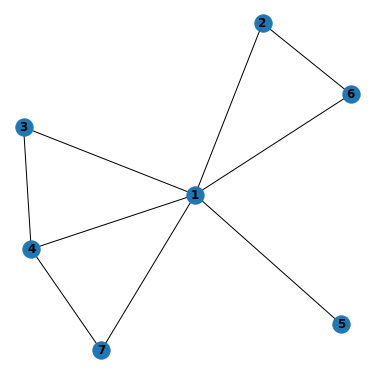

In [ ]:
# отрисовываем наш первый граф
import matplotlib.pyplot as plt 
%matplotlib inline

plt.figure(figsize=(5, 5))

nx.draw(G, with_labels=True, font_weight='bold') # отрисовываем наш граф G

plt.show()


In [ ]:
H = nx.Graph() # второй пустой неориентированный граф
H.add_nodes_from([(1, {'name': 'Эльвира Набиуллина'}),
                  (2, {'name': 'Андреа Орчел'}),
                  (3, {'name': 'Герман Греф'}),
                  (4, {'name': 'Андрей Костин'}),
                  (5, {'name': 'Мария Иванова'}),
                  (6, {'name': 'Кунерт Каролина'}),
                  (7, {'name': 'Игрь Шувалов'})])
H.add_edges_from([(1, 2), (1, 3), (1, 4), (1, 5), (1, 7), (3, 4), (4, 7), (6, 2), (7, 3), (2, 6)]) # добавляем ребра

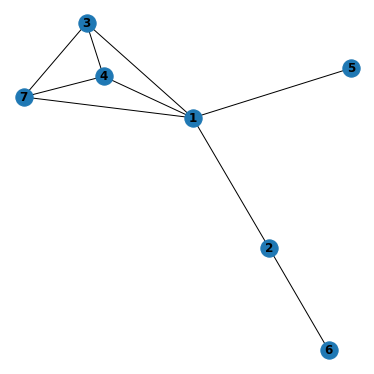

In [ ]:
# рисуем второй граф
import matplotlib.pyplot as plt 
%matplotlib inline

plt.figure(figsize=(5, 5))

nx.draw(H, with_labels=True, font_weight='bold') 

plt.show()

Видим, что в графе H между вершиной 6 и 1 отсутсвует прямая связь

Производем слияние двух Графов, что бы проверить весию о том, выявит новый граф прямую связь между вершинами 6 и 1

In [ ]:
P = nx.compose(G, H) # слияение графов

print(G.edges)
print()
print(P.edges)

[(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 6), (3, 4), (4, 7)]

[(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 6), (3, 4), (3, 7), (4, 7)]


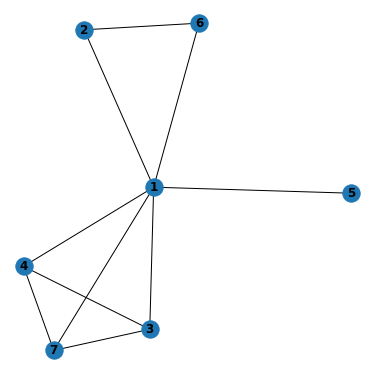

In [ ]:
import matplotlib.pyplot as plt 
%matplotlib inline

plt.figure(figsize=(5, 5))

nx.draw(P, with_labels=True, font_weight='bold') # отрисовываем полученный граф

plt.show()

После слияния графов (граф P) появляется связь между вершиной 1 и 6, которой не было в графе H

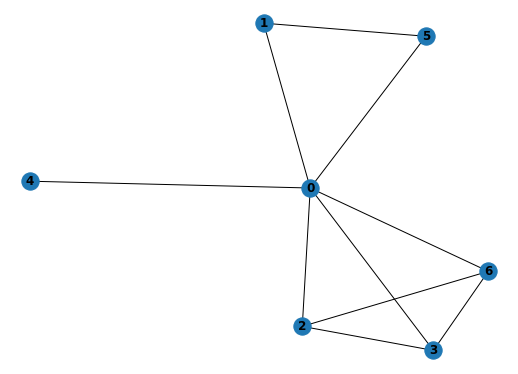

In [ ]:
# фиксируем наш Граф, для представления результата "заказчику"
iP = nx.relabel.convert_node_labels_to_integers(P)
pos = nx.spring_layout(iP)

plt.figure(figsize=(7, 5))
nx.draw(iP, pos, with_labels=True, font_weight='bold')
plt.show()

После выявления новых связей, для представления "заказчику" результата - подписываем вершины и отрисовываем цветом ребра

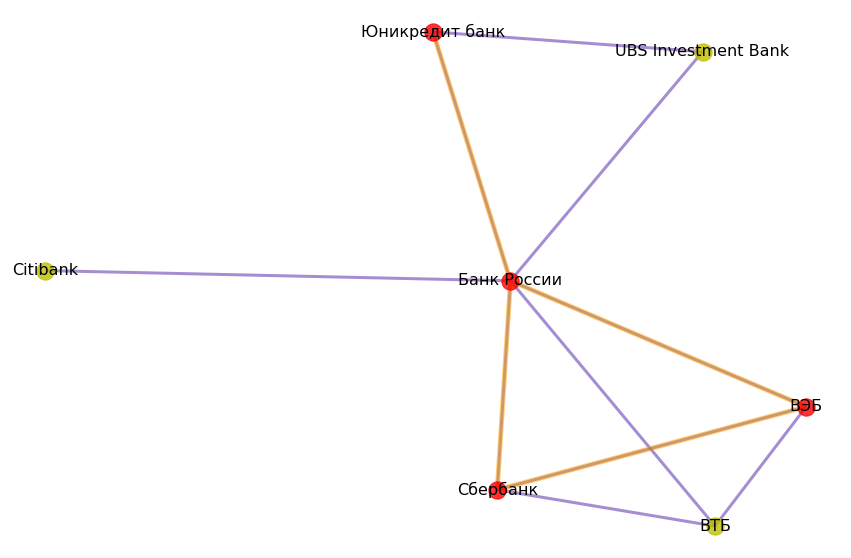

In [ ]:
plt.figure(figsize=(15, 10))
# вершины
options = {"node_size": 300, "alpha": 0.8}
nx.draw_networkx_nodes(iP, pos, nodelist=[2, 1, 0, 6], node_color='r', **options)
nx.draw_networkx_nodes(iP, pos, nodelist=[4, 3, 5], node_color='y', **options)


# ребра
nx.draw_networkx_edges(iP, pos, width=3, edge_color='#4b1ca3', alpha=0.5)
nx.draw_networkx_edges(iP, pos, edgelist=list(iP.subgraph([2, 1, 0, 6]).edges), 
                       width=5, alpha=0.5, edge_color='orange')
nx.draw_networkx_edges(iP, pos, edgelist=list(iP.subgraph([4, 3, 5]).edges), 
                       width=5, alpha=0.5, edge_color='black')


# label вершин 

labels = {k: k for k in list(iP.nodes)}

labels[0] = r"Банк России"
labels[1] = r"Юникредит банк"
labels[2] = r"Сбербанк"
labels[3] = r"ВТБ"
labels[4] = r"Citibank"
labels[5] = r"UBS Investment Bank"
labels[6] = r"ВЭБ"


nx.draw_networkx_labels(iP, pos, labels, font_size=16)

plt.axis("off")
plt.show()